# Imports

In [1]:
import numpy as np
import joblib
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from resources.context import Context as c
from resources.datatransformer import DataTransformer
from resources.modelvalidator import ModelValidator

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Data

## Loading Data

In [3]:
df_prepared = joblib.load(open((c().data_proc_fld() / 'df_prepared.pkl'), 'rb'))

## Data Preparation

In [4]:
X = df_prepared.drop(['product_id', 'label-encoder_category'], axis=1)
y = df_prepared['label-encoder_category']

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5.0. Models Otimization & Features Impact

## 5.1. XGBoost

### 5.1.1. Fine Tuning

In [6]:
# param_grid = {
#             'max_depth': np.arange(3, 18, 3),
#             'gamma': np.arange(3, 9, 3),
#             'reg_alpha' : np.arange(30, 180, 30),
#             'reg_lambda' : np.arange(0, 1, 1),
#             'colsample_bytree' : np.arange(0.5, 1, 0.5),
#             'min_child_weight' : np.arange(0, 10, 2),
#             'n_estimators': np.arange(30, 150, 30)
#             }

In [7]:
# base_estimator = XGBClassifier(random_state=42)
# sh = RandomizedSearchCV(
#                 base_estimator, 
#                 param_grid, 
#                 cv=10, 
#                 n_jobs=-1, 
#                 scoring='neg_mean_absolute_error',
#                 ).fit(X, y)

In [8]:
#sh.best_params_

### 5.1.2. Defining Model

In [9]:
# these params was choosed by the fine tuning process above
xgb_params = {'reg_lambda': 0,
            'reg_alpha': 30,
            'n_estimators': 120,
            'min_child_weight': 8,
            'max_depth': 12,
            'gamma': 6,
            'colsample_bytree': 0.5,
            'objective':'multi:softmax'}

xgb_model = XGBClassifier(**xgb_params)

### 5.1.3. Validations

In [10]:
xgb_model.fit(X, y)
model_validator = ModelValidator(model_name='XGBoost Classifier', model=xgb_model, X=X, y=y)

#### Feature Importance

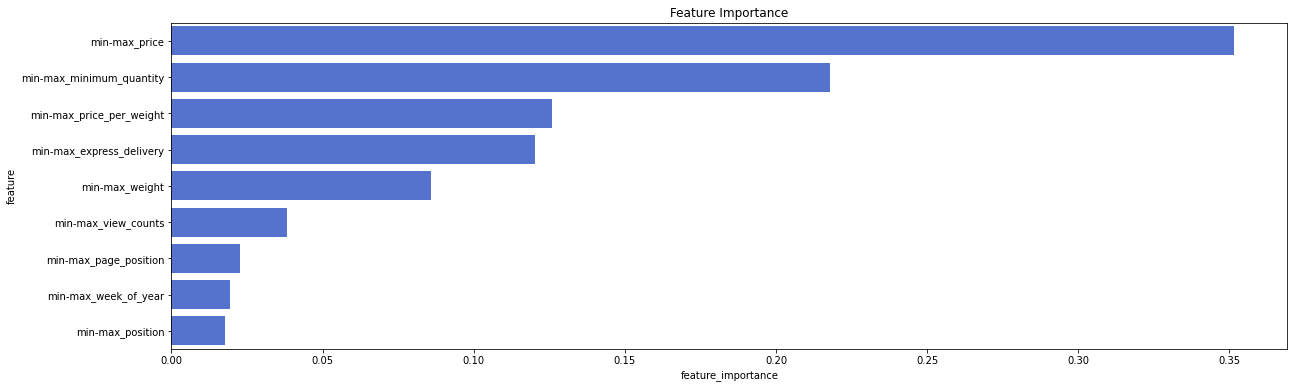

In [11]:
model_validator.plot_feature_importance()

## 5.2. Random Forest

### 5.2.1. Fine Tuning

In [12]:
# param_grid = {
#             'max_depth': np.arange(4, 16, 4),
#             'min_samples_leaf': np.arange(2, 6, 2),
#             'min_samples_split': np.arange(2, 6, 2),
#             'n_estimators': np.arange(30, 150, 30)
#             }

In [13]:
# base_estimator = RandomForestClassifier(random_state=42)
# sh = RandomizedSearchCV(
#                 base_estimator, 
#                 param_grid, 
#                 cv=10, 
#                 n_jobs=-1, 
#                 scoring='neg_mean_absolute_error',
#                 ).fit(X, y)

In [14]:
# sh.best_params_

### 5.2.2. Defining Model

In [15]:
# these params was choosed by the fine tuning process above
rf_params = {'n_estimators': 120,
            'min_samples_split': 2,
            'min_samples_leaf': 4,
            'max_depth': 4,
            'criterion': 'entropy'}

rf_model = RandomForestClassifier(**rf_params)

### 5.2.3. Validations

In [16]:
rf_model.fit(X, y)
model_validator = ModelValidator(model_name='Random Forest Regressor', model=rf_model, X=X, y=y)

#### Feature Importance

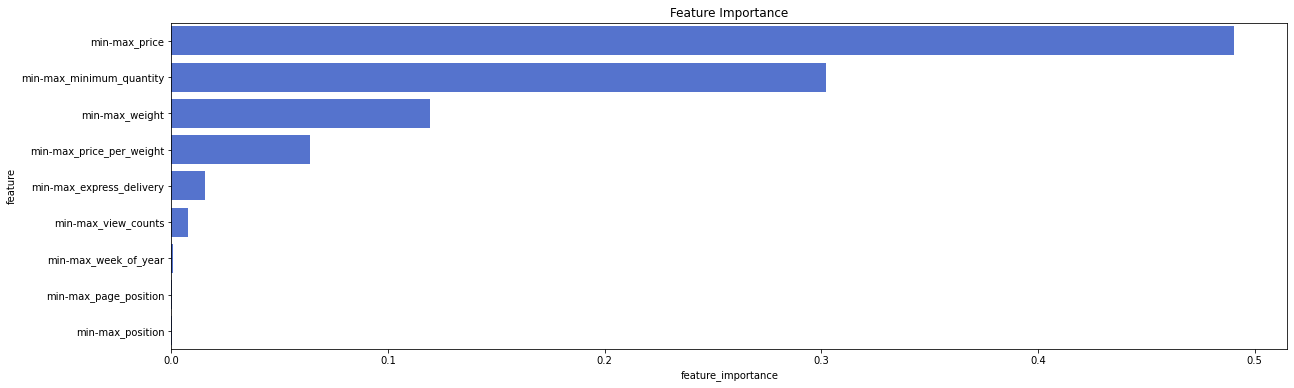

In [17]:
model_validator.plot_feature_importance()

## 5.3. K-Nearest Neighbour

### 5.3.1. Fine Tuning

In [18]:
# param_grid = {
#         'leaf_size': np.arange(5, 50, 5), 
#         'n_neighbors': np.arange(5, 50, 5)
#         }

In [19]:
# base_estimator = KNeighborsClassifier()
# sh = RandomizedSearchCV(
#                 base_estimator, 
#                 param_grid, 
#                 cv=10, 
#                 n_jobs=-1, 
#                 scoring='neg_mean_absolute_error',
#                 ).fit(X, y)

In [20]:
#sh.best_params_

### 5.3.2. Defining Model

In [21]:
# these params was choosed by the fine tuning process above
knn_params = {'n_neighbors': 45, 'leaf_size': 35}
knn_model = KNeighborsClassifier(**knn_params)

## 5.4. Metrics

In [22]:
model_validator = ModelValidator(model_name='Extreme Gradient Boosting Classifier', model=xgb_model, X=X, y=y)
xgb_cv = model_validator.kfolds_cross_val_multiclass(cv=10)

model_validator = ModelValidator(model_name='Random Forest Classifier', model=rf_model, X=X, y=y)
rf_cv = model_validator.kfolds_cross_val_multiclass(cv=10)

model_validator = ModelValidator(model_name='K-Nearest Neighbour Classifier', model=knn_model, X=X, y=y)
knn_cv = model_validator.kfolds_cross_val_multiclass(cv=10)

In [23]:
cv_perf = pd.concat([xgb_cv, rf_cv, knn_cv], axis=0)
cv_perf

# XGBoost aparently to be the most reliable model because their metrics are not very big or very slow
# Then XGBoost is the model who is going to be used in deployment here

,Model Name,Accuracy CV,Kappa CV,Precision CV,Recall CV,F1-Score CV
0,Extreme Gradient Boosting Classifier,0.64,0.45,0.55,0.50,0.50
0,Random Forest Classifier,0.62,0.41,0.49,0.46,0.43
0,K-Nearest Neighbour Classifier,0.49,0.13,0.37,0.31,0.28


# Saving Model

In [24]:
joblib.dump(xgb_model, open(c().models_fld() / 'xgb_class_model.pkl', 'wb'))